In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from class_models import early_stop
import time
from torch.optim.lr_scheduler import StepLR

In [3]:
# setting device and reproducibility
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print(f"Using device: {device}")

Using device: cuda


## Learning schedule to find the best learning rate using *StepLR* scheduler

In [4]:
# import data 
data_frame = pd.read_csv("data/NYCTaxiFares.csv", na_values=["NA", "?"])

In [5]:
# function to calculate the distance of the travel
def haversine_distance(dat_f, lat1, lon1, lat2, lon2):
    
    # average radius of the Earth in (km)
    r = 6371
    
    phi1 = np.radians(dat_f[lat1])
    phi2 = np.radians(dat_f[lat2])
    delta_phi = np.radians(dat_f[lat2] - dat_f[lat1])
    delta_lambda = np.radians(dat_f[lon2] - dat_f[lon1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)
    
    return d

def preprocessing(df_n, cat_cols):
    """
    Preprocesses the data and adds pandas categorical fields to a dataframe.
    :param df_n: pandas dataframe 
    :param cat_cols: list of categorical fields
    :return: pandas dataframe
    """
    # append a 'dist_km' new feature in the dataframe
    df_n['dist_km'] = haversine_distance(df_n, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
    
    # remove outliers
    dfd = df_n[(df_n['fare_amount'] != 49.57) & (df_n['fare_amount'] != 45.00)].copy()
    
    # convert to pd datetime
    dfd['pickup_datetime'] = pd.to_datetime(dfd['pickup_datetime'])
    
    # Correcting pickup_datetime due to daylight savings time (April)
    dfd['EDTdate'] = dfd['pickup_datetime'] - pd.Timedelta(hours=4)
    
    # create new time fields
    dfd['Hour'] = dfd['EDTdate'].dt.hour
    dfd['AMorPM'] = np.where(dfd['Hour']<12, 'am', 'pm')
    dfd['Weekday'] = dfd['EDTdate'].dt.strftime("%a")
    
    # transform to pandas categorical variables
    for cat in cat_cols:
        dfd[cat] = dfd[cat].astype('category')
    
    dfd = dfd.drop(columns=['pickup_datetime'])
    
    return dfd

def model_tensors(df, cat_cols, cont_cols, y_col):
    """
    Get categorical, continuous and label tensors for the model
    :param df: pd dataframe
    :param cat_cols: list of categorical fields
    :param cont_cols: list of continuous fields
    :param y_col: list with the labels
    :return: cats, conts, y tensors
    """
    
    # group the data in categorical continuous and target label    
    cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)
    conts = np.stack([df[col].values for col in cont_cols], axis=1)
    y = df[y_col].values.reshape(-1, 1)

    # Convert to PyTorch tensors
    cats_t = torch.tensor(cats, dtype=torch.int64)
    conts_t = torch.tensor(conts, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    
    return cats_t, conts_t, y_t

def create_embedding_sizes(df, cat_cols):
    """
    Create embedding sizes for PyTorch embedding layers
    :param df: pandas dataframe
    :param cat_cols: list of categorical fields
    :return: emb_sizes list
    """
    # categorical sizes list
    cat_sizes = [len(df[col].cat.categories) for col in cat_cols]

    # embedding sizes list (divide the number of unique entries in each column by two, if the result is greater than 50 select 50)
    emb_sizes = [(size, min(50,(size+1)//2)) for size in cat_sizes]
    
    return emb_sizes



In [6]:
df = preprocessing(data_frame, ['Hour', 'AMorPM', 'Weekday'])

cats, conts, y = model_tensors(df, ['Hour', 'AMorPM', 'Weekday'], ['dist_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], ['fare_amount'])

# number of continuous fields of the conts tensor
n_cont = conts.shape[1]

emb_sizes = create_embedding_sizes(df, ['Hour', 'AMorPM', 'Weekday'])

### Model definition

In [7]:
# Define the model
class TabularModel(nn.Module):
    def __init__(self, emb_sizes, n_cont, out_size, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.batch_norm_cont = nn.BatchNorm1d(n_cont)

        layer_list = []
        n_emb = sum([nf for ni, nf in emb_sizes])
        n_in = n_emb + n_cont
        for i in layers:
            layer_list.append(nn.Linear(n_in, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_in = i

        layer_list.append(nn.Linear(layers[-1], out_size))
        self.layers = nn.Sequential(*layer_list)

    def forward(self, x_cat, x_cont):
        embeddings = [e(x_cat[:, i]) for i, e in enumerate(self.embeds)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.batch_norm_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

### Split Function
Function to split the dataset in 6. `Train data`: cat_train, con_train, y_train; `Test Data`: cat_test, con_test, y_test

In [8]:
def get_train_test(categoricals, continuous, y_train, test_size=0.2):
    # Ensure the input arrays have the same number of rows
    assert categoricals.shape[0] == continuous.shape[0] == y_train.shape[0], "Input arrays must have the same number of rows"

    # Combine the data into a single array for splitting
    combined = np.hstack((categoricals, continuous, y_train))

    # Split and shuffle combined data into train and test sets
    train_data, test_data = train_test_split(combined, test_size=test_size, random_state=42)

    # Determine the number of categorical and continuous columns
    n_cat_cols = categoricals.shape[1]
    n_cont_cols = continuous.shape[1]

    # Separate the train and test data back into categorical, continuous, and target tensors

    # selects all rows and the first n_cat_cols columns (categorical features).
    cat_train = torch.tensor(train_data[:, :n_cat_cols], dtype=torch.int64).to(device)

    # selects all rows and the columns from n_cat_cols to n_cat_cols + n_cont_cols (continuous features).
    con_train = torch.tensor(train_data[:, n_cat_cols:n_cat_cols + n_cont_cols], dtype=torch.float32).to(device)

    # selects all rows and the last column (target labels).
    y_train = torch.tensor(train_data[:, -1], dtype=torch.float32).unsqueeze(1).to(device)

    cat_test = torch.tensor(test_data[:, :n_cat_cols], dtype=torch.int64).to(device)
    con_test = torch.tensor(test_data[:, n_cat_cols:n_cat_cols + n_cont_cols], dtype=torch.float32).to(device)
    y_test = torch.tensor(test_data[:, -1], dtype=torch.float32).unsqueeze(1).to(device)

    return cat_train, con_train, y_train, cat_test, con_test, y_test

cat_train, con_train, y_train, cat_test, con_test, y_test = get_train_test(cats, conts, y)

## General Configuration for all trainings
### Defining a training function for learning schedules 

In [9]:
# Training function
def train(epochs, train_schedule, start_lr, early_s_patience, print_rate):
    """
    :param epochs: int, number of training epochs
    :param train_schedule: list of lists, [[mode, scheduler_step_size, reduction_factor_gamma]]
    :param start_lr: float, starting learning rate
    :param early_s_patience: int, early stopping patience
    :param print_rate: int, printing rate
    :return: Pandas.DataFrame, the results of the training
    """
    results = []
    start_time = time.time()
    for mode, step_size, gamma in train_schedule:
        print(f"Training mode: {mode}")
        
        # model instance (output_size = 1 for regression task)
        model = TabularModel(emb_sizes, conts.shape[1], 1, [400, 300, 200, 100], p=0.4).to(device)
        
        # criteria
        criterion = nn.SmoothL1Loss()

        # TensorDatasets
        train_dataset = TensorDataset(cat_train, con_train, y_train)
        test_dataset = TensorDataset(cat_test, con_test, y_test)

        batch_size = 128

        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # restart optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=start_lr)
        
        if mode == "LR Scheduler":
            # restart learning rate scheduler
            scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
        
        # reset early stop
        early_stopping = early_stop.EarlyStopping(patience=early_s_patience)
        for epoch in range(epochs):
            
            train_losses = []
            val_losses = []
            
            model.train()
            epoch_losses = []
            for cat_batch, con_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(cat_batch, con_batch).flatten()
                loss = torch.sqrt(criterion(y_pred, y_batch.flatten()))  # Use y_batch.flatten() here
                epoch_losses.append(loss.item())
                loss.backward()
                optimizer.step()
        
            train_losses.append(np.mean(epoch_losses))
        
            # Validation
            model.eval()
            with torch.no_grad():
                epoch_val_loss = []
                for cat_batch, con_batch, y_batch in test_loader:
                    y_val = model(cat_batch, con_batch).flatten()
                    val_loss = torch.sqrt(criterion(y_val, y_batch.flatten()))  # Use y_batch.flatten() here
                    epoch_val_loss.append(val_loss.item())
        
                val_losses.append(np.mean(epoch_val_loss))
        
            if (epoch % print_rate == 0 or epoch == epochs - 1) and mode == "LR Scheduler":
                print(f'Epoch {epoch + 1}/{epochs}, T. Loss: {train_losses[-1]:.4f}, V. Loss: {val_losses[-1]:.4f}, Early S: {early_stopping.status}, Gamma: {gamma}, S. Size: {step_size}, L.R. {optimizer.param_groups[0]['lr']:.6f}')
            elif epoch % print_rate == 0 or epoch == epochs - 1: 
                print(f'Epoch {epoch + 1}/{epochs}, T. Loss: {train_losses[-1]:.4f}, V. Loss: {val_losses[-1]:.4f}, Early S: {early_stopping.status}, L.R. {optimizer.param_groups[0]['lr']:.6f}')
            
            results.append({
                "Mode": mode,
                "Gamma": gamma,
                "Step": step_size,
                "Epoch": epoch + 1,
                "Learning Rate": optimizer.param_groups[0]['lr'],
                "Train Loss": train_losses[-1],
                "Validation Loss": val_losses[-1],
            })
            
            if mode == "LR Scheduler":
                scheduler.step()
            
            # Check early stopping
            if early_stopping(model, val_losses[-1]):  # Pass the latest validation loss to early stopping
                print(early_stopping.status)
                break
        
        print(f'Training completed in {time.time() - start_time:.2f} seconds')

    return pd.DataFrame(results)

### Train Schedule 1: 
Compare the results of a constant learning rate schedule vs StepLR configurations

In [29]:
# configuration for constant lr = 0.01
training_epochs = 300
train_lr_schedule = [
    ["No Scheduler", 0, 0], #<- control
    ["LR Scheduler", 15, 0.95],
    ["LR Scheduler", 10, 0.95],
    ["LR Scheduler", 5, 0.95]
]
starting_lr = 0.01
early_stop_patience = 100
printing_rate = 50

results_lr_001 = train(training_epochs, train_lr_schedule, starting_lr, early_stop_patience, printing_rate)

Training mode: No Scheduler
Epoch 1/300, T. Loss: 1.2824, V. Loss: 1.0377, Early S: , L.R. 0.010000
Epoch 51/300, T. Loss: 1.0588, V. Loss: 0.9447, Early S: NO improvement in the last 4 epochs, L.R. 0.010000
Epoch 101/300, T. Loss: 1.0485, V. Loss: 0.9392, Early S: NO improvement in the last 23 epochs, L.R. 0.010000
Epoch 151/300, T. Loss: 1.0397, V. Loss: 0.9573, Early S: NO improvement in the last 4 epochs, L.R. 0.010000
Epoch 201/300, T. Loss: 1.0362, V. Loss: 0.9283, Early S: NO improvement in the last 42 epochs, L.R. 0.010000
Epoch 251/300, T. Loss: 1.0356, V. Loss: 0.9664, Early S: NO improvement in the last 4 epochs, L.R. 0.010000
Epoch 300/300, T. Loss: 1.0346, V. Loss: 0.9097, Early S: NO improvement in the last 53 epochs, L.R. 0.010000
Training completed in 1128.34 seconds
Training mode: LR Scheduler
Epoch 1/300, T. Loss: 1.2858, V. Loss: 1.0435, Early S: , Gamma: 0.95, S. Size: 15, L.R. 0.010000
Epoch 51/300, T. Loss: 1.0545, V. Loss: 0.9340, Early S: NO improvement in the l

In [30]:
# export data
results_lr_001.to_csv("export/results_lr_001.csv", index=False)

In [31]:
# Compute summary statistics

summary_stats = results_lr_001.groupby(['Mode', 'Step']).agg({
    'Train Loss': ['mean', 'std', 'min', 'max'],
    'Validation Loss': ['mean', 'std', 'min', 'max'],
    'Epoch': ['min']
}).reset_index()

print(summary_stats)

           Mode Step Train Loss                               Validation Loss  \
                           mean       std       min       max            mean   
0  LR Scheduler    5   1.033359  0.024957  1.011690  1.289444        0.941576   
1  LR Scheduler   10   1.035469  0.024275  1.012170  1.283989        0.941293   
2  LR Scheduler   15   1.040778  0.023315  1.015861  1.285820        0.944451   
3  No Scheduler    0   1.047666  0.020189  1.030314  1.282439        0.949181   

                                Epoch  
        std       min       max   min  
0  0.018718  0.917399  1.065715     1  
1  0.018541  0.912204  1.026275     1  
2  0.020796  0.912622  1.044538     1  
3  0.024682  0.909700  1.082597     1  


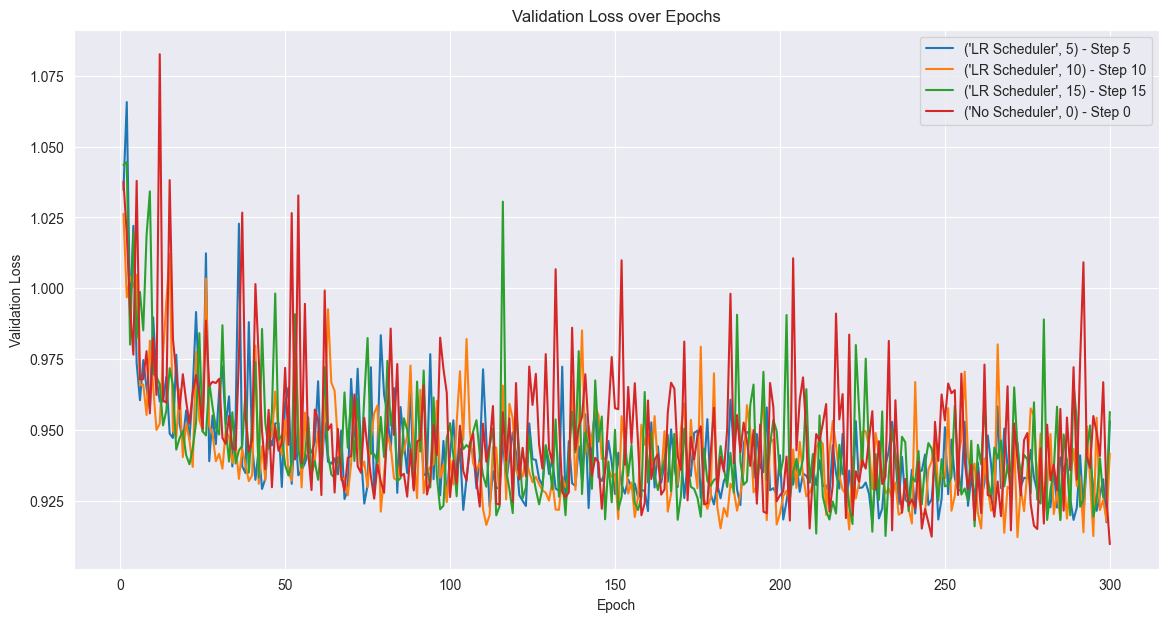

In [32]:
plt.figure(figsize=(14, 7))
for mode, group in results_lr_001.groupby(['Mode', 'Step']):
    plt.plot(group['Epoch'], group['Validation Loss'], label=f'{mode} - Step {group["Step"].iloc[0]}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

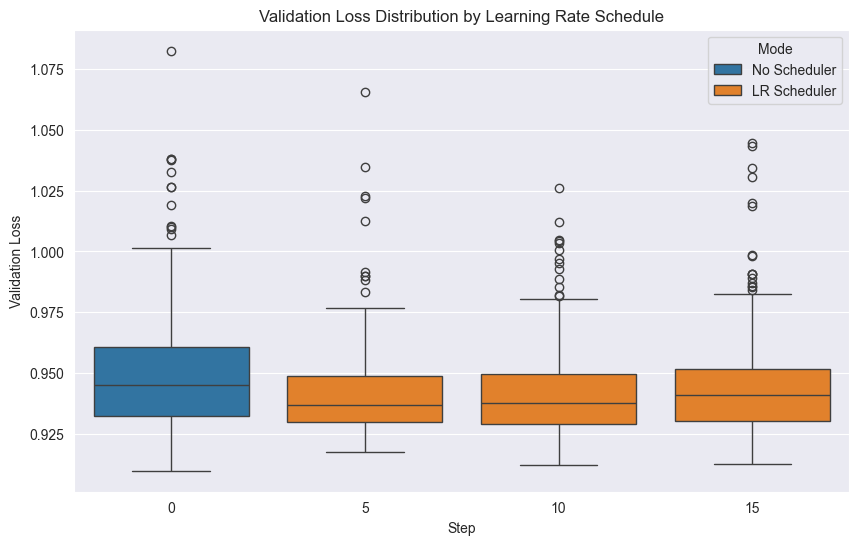

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Step', y='Validation Loss', hue='Mode', data=results_lr_001)
plt.title('Validation Loss Distribution by Learning Rate Schedule')
plt.show()

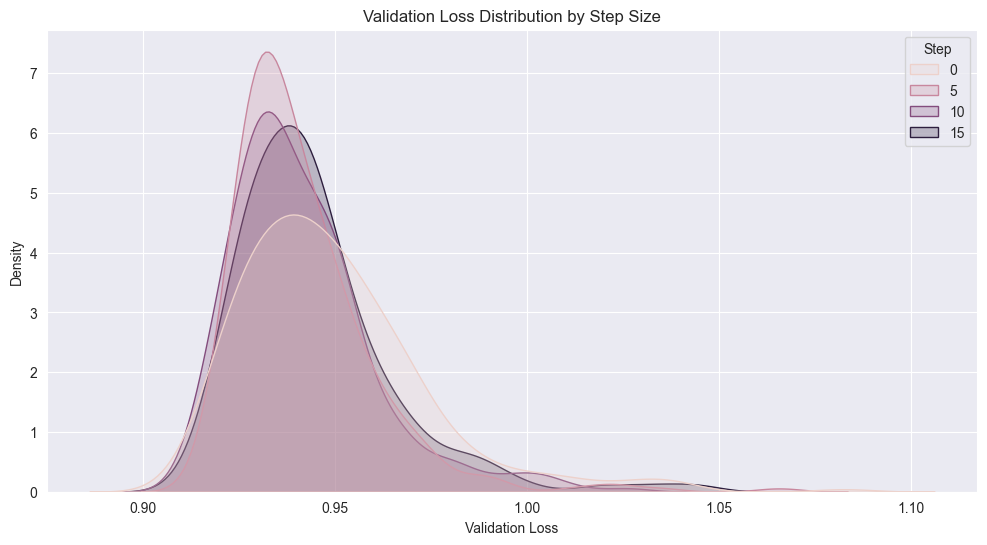

In [35]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=results_lr_001, x='Validation Loss', hue='Step', fill=True)
plt.title('Validation Loss Distribution by Step Size')
plt.xlabel('Validation Loss')
plt.ylabel('Density')
plt.show()

### Train schedule 2

In [10]:
training_epochs = 500
train_lr_schedule = [
    ["NO Scheduler", 0, 0],
    ["LR Scheduler", 50, 0.8],
]
starting_lr = 0.001
early_stop_patience = 100
printing_rate = 50

m_lr=starting_lr*train_lr_schedule[1][2]**(training_epochs/train_lr_schedule[1][1])
print(f'minimum learning rate: {m_lr:.8f}')

results_lr_0001 = train(training_epochs, train_lr_schedule, starting_lr, early_stop_patience, printing_rate)

minimum learning rate: 0.00010737
Training mode: NO Scheduler
Epoch 1/500, T. Loss: 1.7035, V. Loss: 1.0801, Early S: , L.R. 0.001000
Epoch 51/500, T. Loss: 1.0545, V. Loss: 0.9452, Early S: NO improvement in the last 9 epochs, L.R. 0.001000
Epoch 101/500, T. Loss: 1.0354, V. Loss: 0.9339, Early S: NO improvement in the last 23 epochs, L.R. 0.001000
Epoch 151/500, T. Loss: 1.0190, V. Loss: 0.9307, Early S: NO improvement in the last 45 epochs, L.R. 0.001000
Epoch 201/500, T. Loss: 1.0205, V. Loss: 0.9250, Early S: NO improvement in the last 1 epochs, L.R. 0.001000
Epoch 251/500, T. Loss: 1.0141, V. Loss: 0.9399, Early S: NO improvement in the last 45 epochs, L.R. 0.001000
Epoch 301/500, T. Loss: 1.0173, V. Loss: 0.9255, Early S: NO improvement in the last 95 epochs, L.R. 0.001000

Training completed in 1136.68 seconds
Training mode: LR Scheduler
Epoch 1/500, T. Loss: 1.7187, V. Loss: 1.0735, Early S: , Gamma: 0.8, S. Size: 50, L.R. 0.001000
Epoch 51/500, T. Loss: 1.0600, V. Loss: 0.935

In [11]:
results_lr_0001.to_csv("export/results_lr_0001.csv", index=False)

In [12]:
# Compute summary statistics

ts_summary_stats = results_lr_0001.groupby(['Mode', 'Step']).agg({
    'Train Loss': ['mean', 'std', 'min', 'max'],
    'Validation Loss': ['mean', 'std', 'min', 'max'],
    'Epoch': ['min']
}).reset_index()

print(ts_summary_stats)

           Mode Step Train Loss                               Validation Loss  \
                           mean       std       min       max            mean   
0  LR Scheduler   50   1.027195  0.042921  1.003152  1.718700        0.937110   
1  NO Scheduler    0   1.037002  0.049194  1.007973  1.703473        0.938709   

                                Epoch  
        std       min       max   min  
0  0.016652  0.911315  1.073470     1  
1  0.018106  0.916140  1.080053     1  


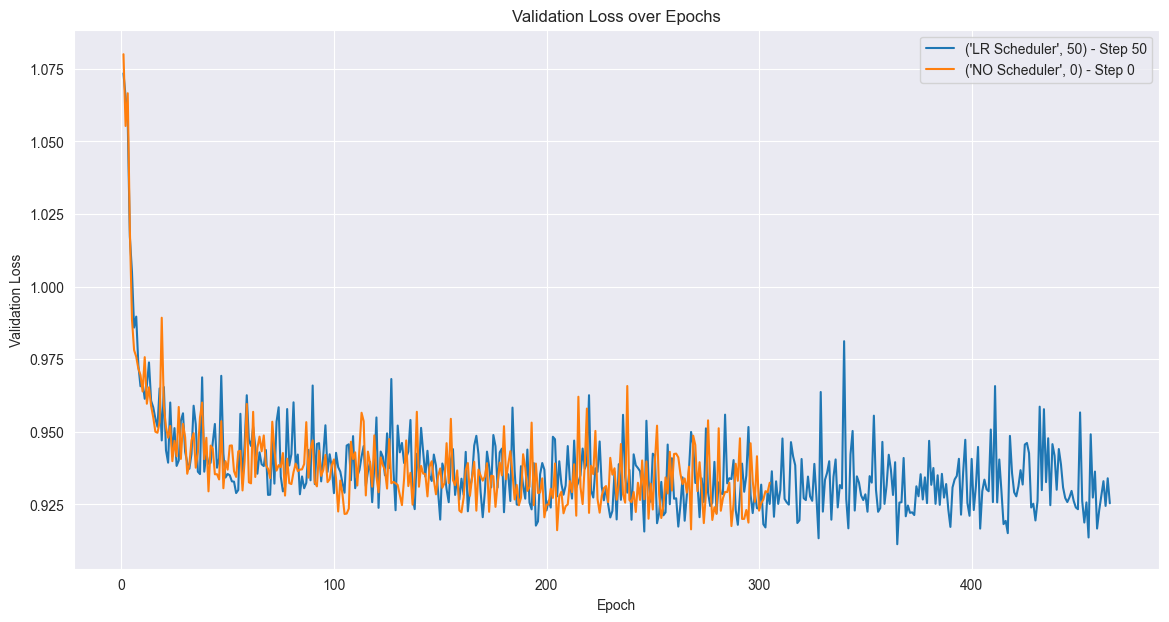

In [13]:
plt.figure(figsize=(14, 7))
for mode, group in results_lr_0001.groupby(['Mode', 'Step']):
    plt.plot(group['Epoch'], group['Validation Loss'], label=f'{mode} - Step {group["Step"].iloc[0]}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

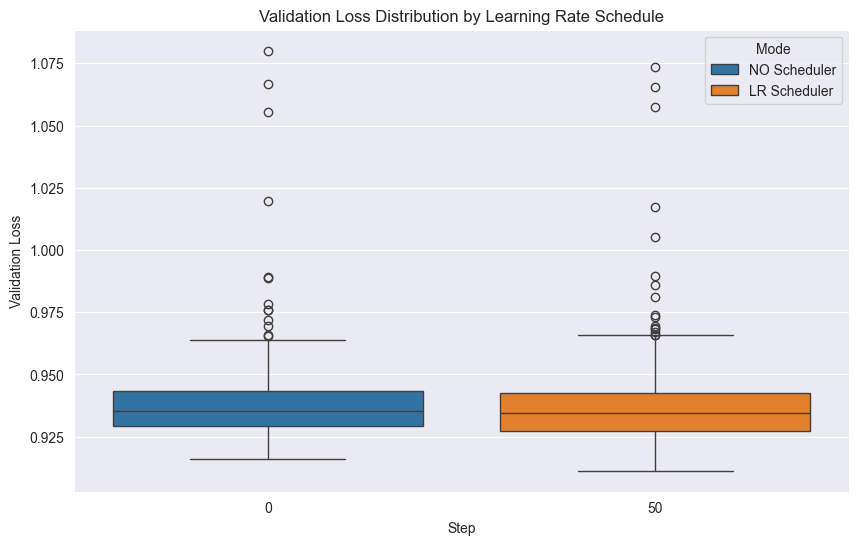

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Step', y='Validation Loss', hue='Mode', data=results_lr_0001)
plt.title('Validation Loss Distribution by Learning Rate Schedule')
plt.show()

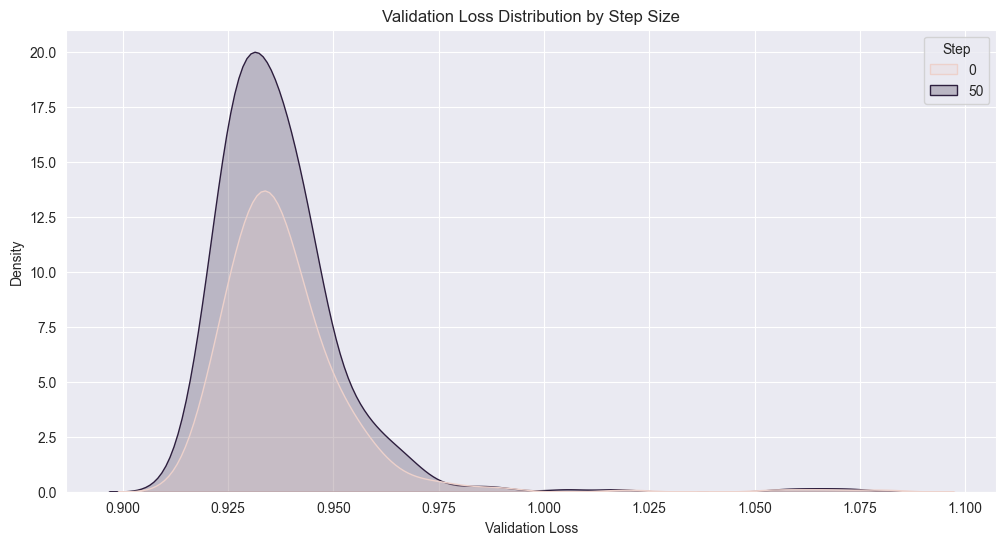

In [16]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=results_lr_0001, x='Validation Loss', hue='Step', fill=True)
plt.title('Validation Loss Distribution by Step Size')
plt.xlabel('Validation Loss')
plt.ylabel('Density')
plt.show()